In [2]:
# %%file obstacle_map3D.py
__author__ = "nipun.dhananjaya@gmail.com"
__date__ = "29.01.2023"

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import trimesh
from trimesh.exchange.ply import parse_header, ply_binary

class OBSTACLE_MAP():
    def __init__(self, ply_path, npz_path):
        self.ROB_MAX_H = 0.4 # max height of the hyperdog
        self.ROB_MIN_H = 0.2 # min height of the heyperdog
        self.ROB_L = 0.5 # Length of hyperdog
        self.ROB_W = 0.35 # width of hyperdog
        self.ROB_MAX_STEP_H = 0.10

        self.npz = self.__load_npz(npz_path)
        self.ply = self.__load_ply(ply_path)
        self.voxel_size = self.npz['voxel_size']
        self.vertex_data = self.ply['vertex']['data']
        self.vertex_len = self.ply['vertex']['length']
        self.max_3dMap_z = int(round(self.ROB_MAX_H/self.voxel_size))*10

        # below variables will be updated once data_update() function runs
        self.max_x = 0
        self.max_y = 0
        self.floor_coord = []
        self.floor_min_z = 10000
        self.floor_max_z = 0
        self.object_coord = None
        self.obstacle_coord = []
        self.__data_update()

        self.floor_h_map, self.floor_2d_map = self.__get_floor_map()
        self.object_3dMap = self.__get_object_3dMap()
        """ `object map` free space: 0, occupied:1"""
        self.obstacle_list = []
        self.obstacle_map_NONadaptive_h = self.__get_obstacle_map(rob_change_h=False)
        """Obstacle map where robot's adaptive height is not considered"""
        self.obstacle_map_adaptive_h = self.__get_obstacle_map(rob_change_h=True)
        """Obstacle map with information of robot height where robot can overcome obstacle changing its height"""
        
        
    
    def __load_npz(self, path):
        return np.load(path)
    
    def __load_ply(self, path):
        with open(path, 'rb') as f:
            elements, is_ascii, image_name = parse_header(f)
            ply_binary(elements, f)
        return elements

    def __data_update(self):
        for d in self.vertex_data:
            if self.max_x < d[0]: self.max_x = d[0]
            if self.max_y < d[1]: self.max_y = d[1]
            if d[7] == 2: # floor segment number is 2
                self.floor_coord.append([d[0], d[1], d[2]])
                if self.floor_min_z > d[2]: self.floor_min_z = d[2]
                if self.floor_max_z < d[2]: self.floor_max_z = d[2]
            else:
                self.obstacle_coord.append([d[0], d[1], d[2]])
        self.max_x = int(round(self.max_x/self.voxel_size + 1))
        self.max_y = int(round(self.max_y/self.voxel_size + 1))
        self.floor_max_z = self.floor_max_z/self.voxel_size
        self.floor_min_z = self.floor_min_z/self.voxel_size
        self.floor_coord = np.array(self.floor_coord)/self.voxel_size
        self.object_coord = np.array(self.obstacle_coord)/self.voxel_size

    def __get_floor_map(self):
        floor_h_map = np.ones([self.max_x, self.max_y])*-1
        floor_2d_map = np.ones([self.max_x, self.max_y])*-1
        for d in self.floor_coord:
            x = int(round(d[0]))
            y = int(round(d[1]))
            floor_h_map[x,y] = d[2]
            floor_2d_map[x,y] = 1
        return floor_h_map, floor_2d_map
    
    def __get_object_3dMap(self):
        obj_map = np.zeros([self.max_x, self.max_y, self.max_3dMap_z])
        for d in self.object_coord:
            x = abs(int(round(d[0])))
            y = abs(int(round(d[1])))
            z = abs(int(round(d[2]*10 - self.floor_h_map[x,y]*10)))
            if z < self.max_3dMap_z:
                obj_map[x,y,z] = 1
        return obj_map

    def __get_obstacle_map(self, rob_change_h):
        # obs_map = np.ones([self.max_x, self.max_y])*0.4
        obs_map = np.zeros([self.max_x, self.max_y])
            # obs_map[x,y] : -1=obstacle |  0=free to move |  -1< and <0=can move changing step height |  0< and <1=can move changing robot height
        self.obstacle_list = []
        for x in range(self.floor_2d_map.shape[0]):
            for y in range(self.floor_2d_map.shape[1]):
                if self.floor_2d_map[x,y] == -1:
                    obs_map[x,y] = -1
                else:
                    for z in range(len(self.object_3dMap[x,y])):
                        # if obsacle found
                        if self.object_3dMap[x,y,z] == 1:
                            # if there is an obs higher than MAX_STEP_H and lower than ROB_MIN_H, robot can't move
                            if z/10 > self.ROB_MAX_STEP_H/self.voxel_size and z/10 <= self.ROB_MIN_H/self.voxel_size:
                                obs_map[x,y] = -1
                            # else, is there is an obstacle above ROB_MIN_H and below ROB_MAX_H, robot can move by changing height
                            elif z/10 > self.ROB_MIN_H/self.voxel_size and z/10 < self.ROB_MAX_H/self.voxel_size:
                                if rob_change_h: obs_map[x,y] = z/10*self.voxel_size
                                else: obs_map[x,y] = -1
                                self.obstacle_list.append((x,y,z/10*self.voxel_size))
                                # obs_map[x,y] = -1 # uncomment this and comment above line when u dont cnsider changing height of the robot
        return obs_map        

    def save_3D_obstacle_map_obj(self, obj_path):
        obj_r = list(open('sample1.obj', "r"))
        obj_w = open('obstacle_3dMap.obj', "w")

        floor_r = '0.59607843'
        # floor_r = 123
        floor_g = '0.87450980'
        # floor_b = 104
        floor_b = '0.54117647'
        # floor_g = 200
        for line in obj_r:
            if line.startswith('#'): 
                continue
            values = line.split()
            if not values: 
                continue
            if values[0] == 'v':
                z = float(values[3])
                if z <= self.ROB_MAX_H + self.floor_max_z*self.voxel_size \
                        and z >= self.floor_min_z*self.voxel_size:
                    x = float(values[1])
                    y = float(values[2])

                    # floor area
                    if values[4] == floor_r and values[5] == floor_g and values[6] == floor_b:            
                        # free to move area
                        if self.obstacle_map_adaptive_h[int(round(x/self.voxel_size)), int(round(y/self.voxel_size))] == 0:
                            r = 0.0
                            g = 0.0
                            b = 1.0
                        # area where movable changing height
                        else:
                            h = self.obstacle_map_adaptive_h[int(round(x/self.voxel_size)), int(round(y/self.voxel_size))]
                            # floor area robot can't move
                            if h == -1:
                                r = 0.0
                                g = 0.0 
                                b = 1.0
                            # floor area robot can move adapting height
                            else:
                                r = 0.0
                                g = 0.0
                                b = 1.0
                    
                    # NON_floor area
                    else:
                        h = self.obstacle_map_adaptive_h[int(round(x/self.voxel_size)), int(round(y/self.voxel_size))]
                        if h == -1:
                            r = 1.0
                            g = 0.0 
                            b = 0.0
                        else:
                            r = 1.0
                            g = 0.8
                            b = 0.0
                    temp_line = f"{values[0]} {values[1]}  {values[2]} {values[3]} {r} {g} {b}\n"
                    obj_w.write(temp_line)

                else:
                    continue
        print("file is saved as obstacle_3dMap.obj")


In [3]:
path_ply = '/home/iana/results-drone-dog/sample1.ply'
path_npz = '/home/iana/results-drone-dog/sample1.npz'

map_ = OBSTACLE_MAP(path_ply, path_npz)
map_.save_3D_obstacle_map_obj('sample1.obj')

file is saved as obstacle_3dMap.obj


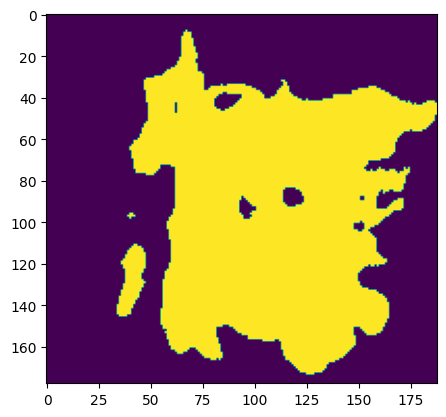

In [93]:
# Floor map
plt.imshow(map_.floor_2d_map)

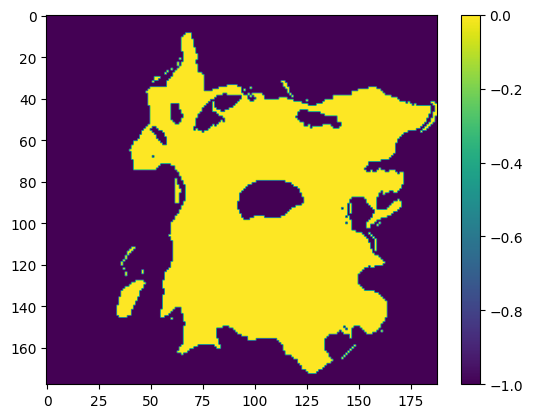

In [94]:
# obstacle map for NONE ADAPTIVE HEIGHT
plt.colorbar(plt.imshow(map_.obstacle_map_NONadaptive_h))

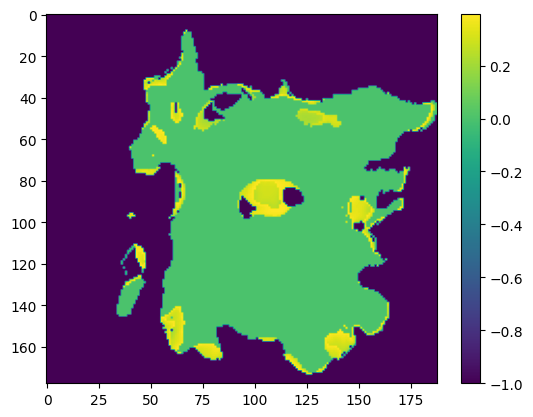

In [95]:
# obstacle map for ADAPTIVE HEIGHT
plt.colorbar(plt.imshow(map_.obstacle_map_adaptive_h))

### extract 3D object map which reprecent robot's movable area

In [65]:
map_.save_3D_obstacle_map_obj('sample1.obj')

file is saved as obstacle_3dMap.obj


In [72]:
obj_r = list(open('sample1.obj', "r"))
obj_w = open('procesed.obj', "w")

floor_r = '0.59607843'
floor_g = '0.87450980'
floor_b = '0.54117647'
for line in obj_r:
    if line.startswith('#'): 
        continue
    values = line.split()
    if not values: 
        continue
    if values[0] == 'v':
        z = float(values[3])
        if z <= map_.ROB_MAX_H + map_.floor_max_z*map_.voxel_size \
                and z >= map_.floor_min_z*map_.voxel_size:
            x = float(values[1])
            y = float(values[2])

            # floor area
            if values[4] == floor_r and values[5] == floor_g and values[6] == floor_b:            
                # free to move area
                if map_.obstacle_map_adaptive_h[int(round(x/map_.voxel_size)), int(round(y/map_.voxel_size))] == 0:
                    r = floor_b
                    g = floor_g
                    b = floor_b

                # area where movable changing height
                else:
                    h = map_.obstacle_map_adaptive_h[int(round(x/map_.voxel_size)), int(round(y/map_.voxel_size))]
                    if h == -1:
                        r = 0.9
                        g = 0.0 
                        b = 0.05
                    else:
                        r = 0.8
                        g = 0.8
                        b = 0.0

            # NON-floor area
            else:
                h = map_.obstacle_map_adaptive_h[int(round(x/map_.voxel_size)), int(round(y/map_.voxel_size))]
                if h == -1:
                    r = 0.9
                    g = 0.0
                    b = 0.05
                else:
                    r = 0.8
                    g = 0.8
                    b = 0.0
            temp_line = f"{values[0]} {values[1]}  {values[2]} {values[3]} {r} {g} {b}\n"
            obj_w.write(temp_line)

        else:
            continue



